##IMPORTAR LIBRERIAS


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import kagglehub

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

##CARGA Y EXPLORACIÓN DE DATOS

In [ ]:
print("=== CARGANDO DATOS ===")
# Carga del datasets
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")

credit_record = pd.read_csv(path + '/credit_record.csv')
applications = pd.read_csv(path + '/application_record.csv')

# Une los conjuntos de datos en la columna 'ID'
merged_data = pd.merge(applications, credit_record, on='ID', how='left')

# Exploracion de Datos
print("Forma del dataset:", merged_data.shape)
print("\nColumnas:", merged_data.columns.tolist())
print("\nValores faltantes:")
print(merged_data.isnull().sum())


=== CARGANDO DATOS ===


100%|██████████| 5.32M/5.32M [00:00<00:00, 60.9MB/s]

Extracting files...


Forma del dataset: (1179815, 20)

Columnas: ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS']

Valores faltantes:
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        362928
CNT_FAM_MEMBERS             0
MONTHS_BALANCE         402100
STATUS                 402100

##INGENIERÍA DE CARACTERÍSTICAS

In [ ]:
print("\n=== INGENIERÍA DE CARACTERÍSTICAS ===")

# Crear variable objetivo basado en STATUS
def create_target(status):

    if pd.isna(status):
        return np.nan
    elif status in ['C', 'X']:
        return 1  # Buen Credito
    else:
        return 0  # Mal Credito

merged_data['target'] = merged_data['STATUS'].apply(create_target)

# Elimina las filas con el valor objetivo faltante
clean_data = merged_data.dropna(subset=['target']).copy()

# Ingeniería de características
print("Creando nuevas características...")

# Edad a partir de los días desde el nacimiento
clean_data['AGE'] = abs(clean_data['DAYS_BIRTH']) // 365

# Años de Empleo
clean_data['EMPLOYMENT_YEARS'] = abs(clean_data['DAYS_EMPLOYED']) // 365

# Ingreso por miembro de la familia
clean_data['INCOME_PER_PERSON'] = clean_data['AMT_INCOME_TOTAL'] / clean_data['CNT_FAM_MEMBERS']

print(f"Datos limpios: {clean_data.shape[0]} registros")


=== INGENIERÍA DE CARACTERÍSTICAS ===
Creando nuevas características...
Datos limpios: 777715 registros


##PREPROCESAMIENTO DE DATOS

In [ ]:
print("\n=== PREPROCESAMIENTO ===")

# Codifica las variables categóricas
le_dict = {}
categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                   'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                   'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

for col in categorical_cols:
    if col in clean_data.columns:
        le = LabelEncoder()
        clean_data[col] = le.fit_transform(clean_data[col].fillna('Unknown'))
        le_dict[col] = le

# Selecciona las características para el modelado
feature_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
               'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
               'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'AGE', 'EMPLOYMENT_YEARS',
               'CNT_FAM_MEMBERS', 'INCOME_PER_PERSON']

# Manejo de los valores faltantes.
X = clean_data[feature_cols].fillna(clean_data[feature_cols].median())
y = clean_data['target']

print(f"Características seleccionadas: {len(feature_cols)}")
print(f"Distribución del target: {y.value_counts().to_dict()}")


=== PREPROCESAMIENTO ===
Características seleccionadas: 13
Distribución del target: {1.0: 475486, 0.0: 302229}


##ENTRENAMIENTO DEL MODELO

In [ ]:
print("\n=== ENTRENAMIENTO DEL MODELO ===")

# Separar Datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Realizar Predicciones
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Modelo entrenado exitosamente!")


=== ENTRENAMIENTO DEL MODELO ===
Modelo entrenado exitosamente!


##EVALUACIÓN DEL MODELO

In [ ]:
print("\n=== RENDIMIENTO DEL MODELO ===")
print(f"Precisión: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Importancia de Caracteristicas
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== IMPORTANCIA DE CARACTERÍSTICAS ===")
print(feature_importance)

# ROC-AUC Puntaje
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"\nPuntaje ROC-AUC: {roc_auc:.4f}")


=== RENDIMIENTO DEL MODELO ===
Precisión: 0.6946

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63     60446
         1.0       0.77      0.72      0.74     95097

    accuracy                           0.69    155543
   macro avg       0.68      0.69      0.68    155543
weighted avg       0.70      0.69      0.70    155543


=== IMPORTANCIA DE CARACTERÍSTICAS ===
                feature  importance
9                   AGE    0.246256
12    INCOME_PER_PERSON    0.158659
4      AMT_INCOME_TOTAL    0.155431
10     EMPLOYMENT_YEARS    0.146801
7    NAME_FAMILY_STATUS    0.044960
5      NAME_INCOME_TYPE    0.042990
2       FLAG_OWN_REALTY    0.037782
1          FLAG_OWN_CAR    0.034367
8     NAME_HOUSING_TYPE    0.029267
0           CODE_GENDER    0.028694
6   NAME_EDUCATION_TYPE    0.026836
11      CNT_FAM_MEMBERS    0.026498
3          CNT_CHILDREN    0.021460

Puntaje ROC-AUC: 0.7622


##VISUALIZACIONES


=== GENERANDO VISUALIZACIONES ===


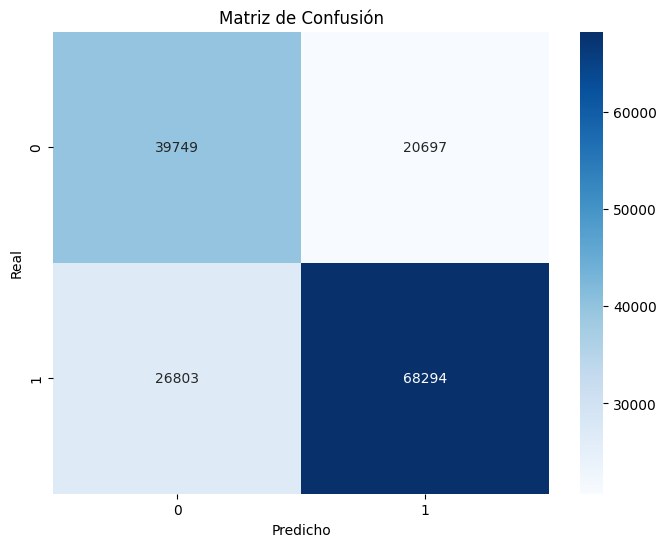

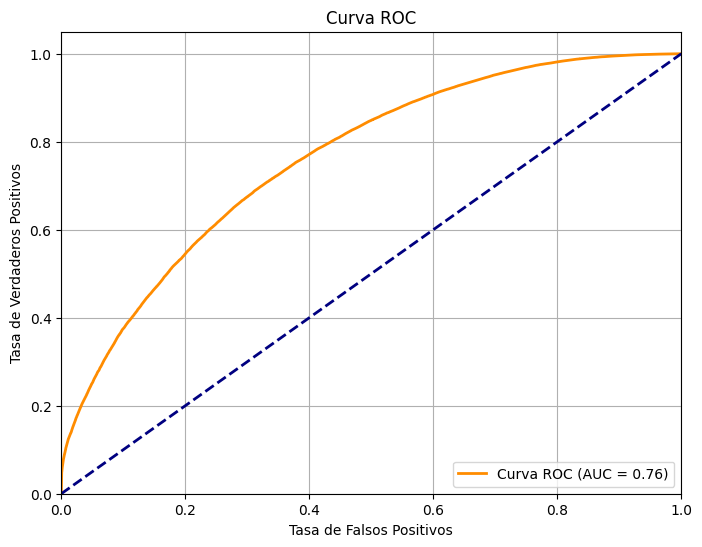

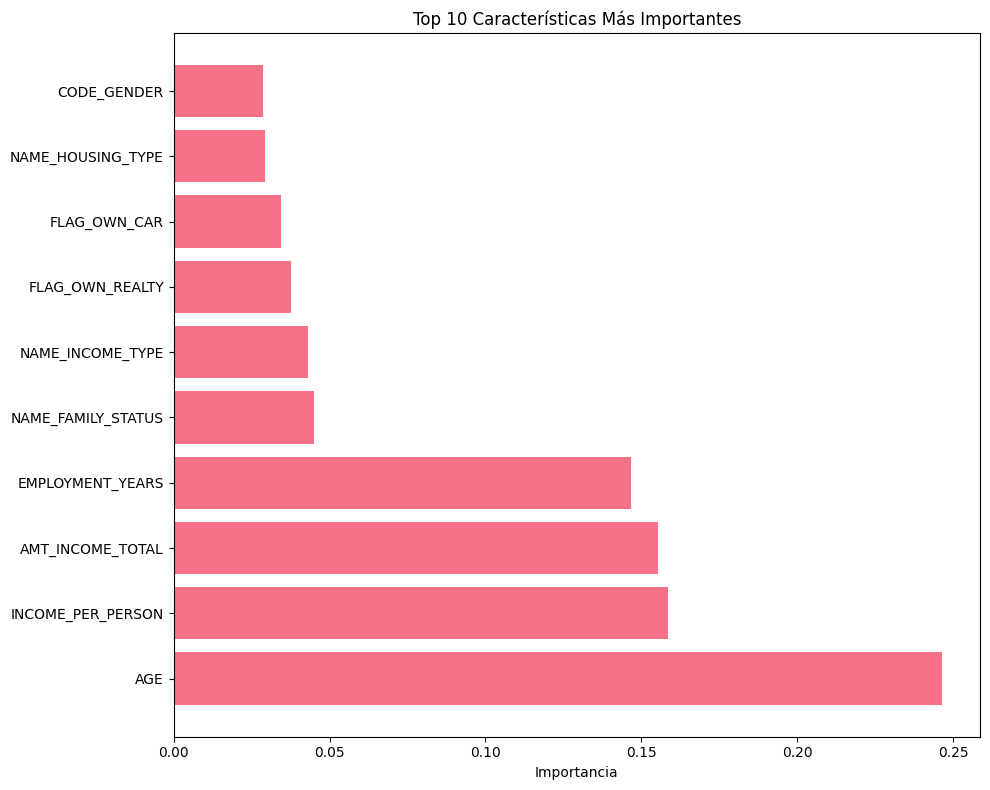

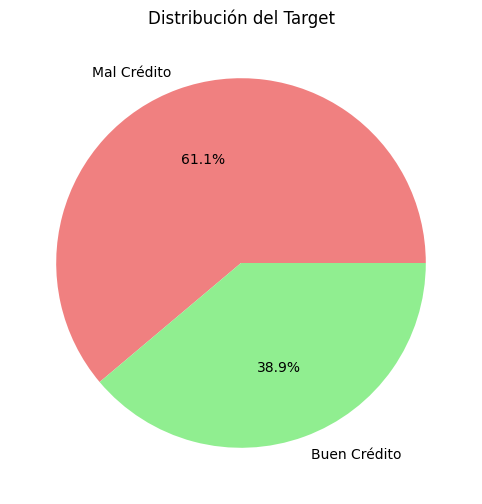

In [ ]:
print("\n=== GENERANDO VISUALIZACIONES ===")

# 1. Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# 2. Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3. Importancia de Características
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 10 Características Más Importantes')
plt.tight_layout()
plt.show()

# 4. Distribución del Objetivo
plt.figure(figsize=(8, 6))
target_counts = clean_data['target'].value_counts()
plt.pie(target_counts.values, labels=['Mal Crédito', 'Buen Crédito'], autopct='%1.1f%%',
        colors=['lightcoral', 'lightgreen'])
plt.title('Distribución del Target')
plt.show()

##FUNCIÓN DE PREDICCIÓN

In [ ]:
def predict_approval(model, le_dict, **kwargs):
    """
    Predice la aprobación de tarjeta de crédito para un nuevo solicitante

    Parámetros:
    -----------
    model : sklearn model
        Modelo entrenado
    le_dict : dict
        Diccionario de encoders para variables categóricas
    **kwargs : dict
        Características del solicitante

    Retorna:
    --------
    dict : Resultado de la predicción con probabilidad y recomendación
    """
    sample = pd.DataFrame([kwargs])

    # Aplicar Transformaciones
    if 'DAYS_BIRTH' in sample.columns:
        sample['AGE'] = abs(sample['DAYS_BIRTH']) // 365
    if 'DAYS_EMPLOYED' in sample.columns:
        sample['EMPLOYMENT_YEARS'] = abs(sample['DAYS_EMPLOYED']) // 365
    if 'AMT_INCOME_TOTAL' in sample.columns and 'CNT_FAM_MEMBERS' in sample.columns:
        sample['INCOME_PER_PERSON'] = sample['AMT_INCOME_TOTAL'] / sample['CNT_FAM_MEMBERS']

    # Codificar Variables Categoricas
    for col in le_dict:
        if col in sample.columns:
            try:
                sample[col] = le_dict[col].transform(sample[col])
            except ValueError:
                sample[col] = 0  # Categoria Desconocida

    # Selecciona las características y completa los valores faltantes
    X_sample = sample[feature_cols].fillna(X.median())

    probability = model.predict_proba(X_sample)[0][1]
    prediction = model.predict(X_sample)[0]

    return {
        'probabilidad_aprobacion': probability,
        'aprobado': bool(prediction),
        'recomendacion': 'Aprobar' if prediction else 'Rechazar'
    }

##EJEMPLO DE USO

In [ ]:
print("\n=== MODELO LISTO PARA PREDICCIONES ===")
print("Usa la función predict_approval() para hacer predicciones de nuevos solicitantes")

# Ejemplo de uso:
ejemplo_prediccion = predict_approval(
    rf_model, le_dict,
    CODE_GENDER='M',
    FLAG_OWN_CAR='Y',
    FLAG_OWN_REALTY='Y',
    CNT_CHILDREN=1,
    AMT_INCOME_TOTAL=50000,
    NAME_INCOME_TYPE='Working',
    NAME_EDUCATION_TYPE='Higher education',
    NAME_FAMILY_STATUS='Married',
    NAME_HOUSING_TYPE='House / apartment',
    CNT_FAM_MEMBERS=3,
    DAYS_BIRTH=-15000,
    DAYS_EMPLOYED=-2000
)

print("\nEjemplo de predicción:")
print(ejemplo_prediccion)


=== MODELO LISTO PARA PREDICCIONES ===
Usa la función predict_approval() para hacer predicciones de nuevos solicitantes

Ejemplo de predicción:
{'probabilidad_aprobacion': np.float64(0.33629289052481004), 'aprobado': False, 'recomendacion': 'Rechazar'}
